In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
import tensorflow as tf  
from tensorflow.keras import datasets, layers, models  
import numpy as np  
import matplotlib.pyplot as plt

Load MINST dataset

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()  
train_images, test_images = train_images / 255.0, test_images / 255.0

11490434/11490434 [==============================] - 1s 0us/step


MNIST is a simple dataset, so a simple model allows us to achieve a test accuracy of more than 99%. We use a standard CNN with three convolutional layers:

In [3]:
def get_model():  
    model = models.Sequential()  
    model.add(  
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1))  
    )  
    model.add(layers.MaxPooling2D((2, 2)))  
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))  
    model.add(layers.MaxPooling2D((2, 2)))  
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))  
    model.add(layers.Flatten())  
    model.add(layers.Dense(64, activation="relu"))  
    model.add(layers.Dense(10))  
    return model  


model = get_model()

We can then compile and train our model. We obtain a validation accuracy of over 99% after just 5 epochs.

In [7]:
def fit_model(model):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    model.fit(  
        train_images,  
        train_labels,  
        epochs=5,  
        validation_data=(test_images, test_labels),  
    )  
    return model  


model = fit_model(model)

Epoch 1/5


1875/1875 [==============================] - 22s 11ms/step - loss: 0.1444 - accuracy: 0.9547 - val_loss: 0.0495 - val_accuracy: 0.9854
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0449 - accuracy: 0.9859 - val_loss: 0.0307 - val_accuracy: 0.9904
Epoch 3/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0327 - accuracy: 0.9898 - val_loss: 0.0328 - val_accuracy: 0.9902
Epoch 4/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0255 - accuracy: 0.9918 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0368 - val_accuracy: 0.9893


Now, let’s see how this model handles out-of-distribution data. Imagine we deploy this model to recognize digits, but users sometimes fail to write down the entire digit. What happens when users do not write down the entire digit? We can get an answer to this question by gradually removing more and more information from a digit, and seeing how our model handles the perturbed inputs. We can define our function to remove signal as follows:

In [9]:
def remove_signal(img: np.ndarray, num_lines: int) -> np.ndarray:  
   img = img.copy()  
   img[:num_lines] = 0  
   return img

And then we perturb our images:

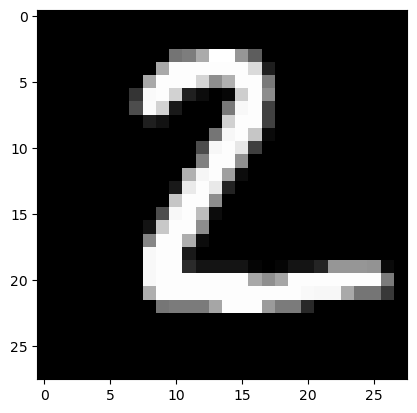

In [11]:
img = test_images[1]
plt.imshow(img, cmap="gray")
plt.show()

In [12]:
imgs = []  
for i in range(28):  
   img_perturbed = remove_signal(img, i)  
   if np.array_equal(img, img_perturbed):  
     continue  
   imgs.append(img_perturbed)  
   if img_perturbed.sum() == 0:  
     break

We only add perturbed images to our list of images if setting a row to 0 actually changes the original image ( if np.array_equal(img, img_perturbed)) and stop once the image is completely black, meaning it just contains pixels with a value of 0. We run inference on these images:

In [13]:
softmax_predictions = tf.nn.softmax(model(np.expand_dims(imgs, -1)), axis=1)

We can then plot all images with their predicted labels and confidence scores:

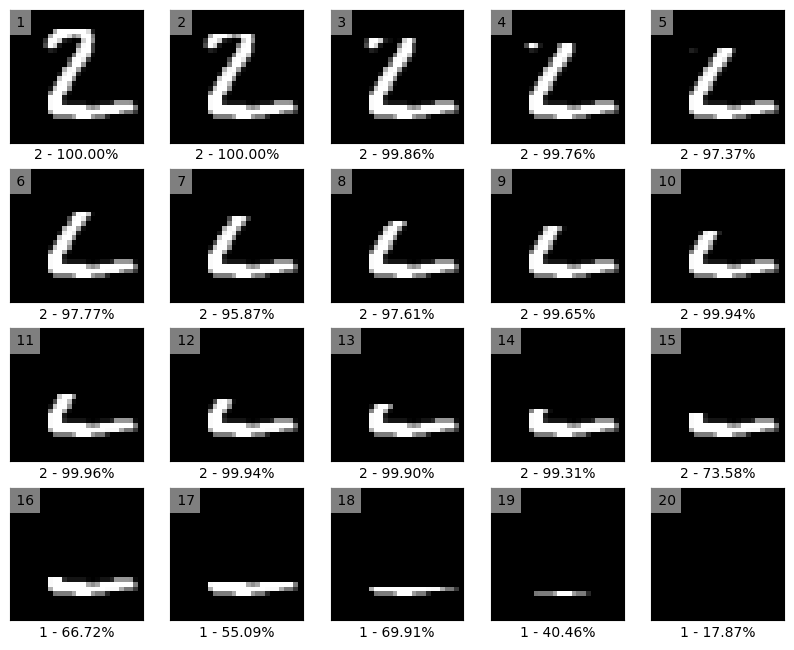

In [27]:
plt.figure(figsize=(10, 10))  
bbox_dict = dict(  
    fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0  
)  
for i in range(len(imgs)):  
    plt.subplot(5, 5, i + 1)  
    plt.xticks([])  
    plt.yticks([])  
    plt.grid(False)  
    plt.imshow(imgs[i], cmap="gray")  
    prediction = softmax_predictions[i].numpy().max()  
    label = np.argmax(softmax_predictions[i])  
    plt.xlabel(f"{label} - {prediction:.2%}")  
    plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
plt.show()

We can see that initially, our model confidently classifies the image as a 2. Remarkably, this confidence persists even when it seems unreasonable to do so. 

For example, the model still classifies image 14 as a 2 with 99.31% confidence. 

Moreover, the model predicts with 69.91% confidence that a completely horizontal line is a 1, as we can see in image 18. 

It looks like our model is overconfident in its predictions.

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [17]:
def get_dropout_model():  
    model = models.Sequential()  
    model.add(  
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1))  
    )  
    model.add(layers.Dropout(0.2))  
    model.add(layers.MaxPooling2D((2, 2)))  
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))  
    model.add(layers.MaxPooling2D((2, 2))
             )  
    model.add(layers.Dropout(0.5))  
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Flatten())  
    model.add(layers.Dense(64, activation="relu"))
    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Dense(10))  
    return model

Then let’s instantiate it:

In [18]:
dropout_model = get_dropout_model()  
dropout_model = fit_model(dropout_model)

Epoch 1/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.4289 - accuracy: 0.8633 - val_loss: 0.0620 - val_accuracy: 0.9808
Epoch 2/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1624 - accuracy: 0.9534 - val_loss: 0.0434 - val_accuracy: 0.9870
Epoch 3/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1354 - accuracy: 0.9609 - val_loss: 0.0358 - val_accuracy: 0.9897
Epoch 4/5
1875/1875 [==============================] - 38s 21ms/step - loss: 0.1173 - accuracy: 0.9665 - val_loss: 0.0313 - val_accuracy: 0.9904
Epoch 5/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1068 - accuracy: 0.9700 - val_loss: 0.0272 - val_accuracy: 0.9922


Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [22]:
predictions = np.array(  
    [  
        tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
        for _ in range(100)  
    ]  
)  
predictions_mean = np.mean(predictions, axis=0)  

This again produces a figure showing the predicted labels and their associated confidence scores:

In [32]:
def plot_predictions(predictions, imgs):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(  
        fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0  
    )  
    for i in range(len(predictions)):  
        plt.subplot(5, 5, i + 1)  
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)  
        plt.imshow(imgs[i], cmap="gray")  
        prediction = predictions[i].max()  
        label = np.argmax(predictions[i])  
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

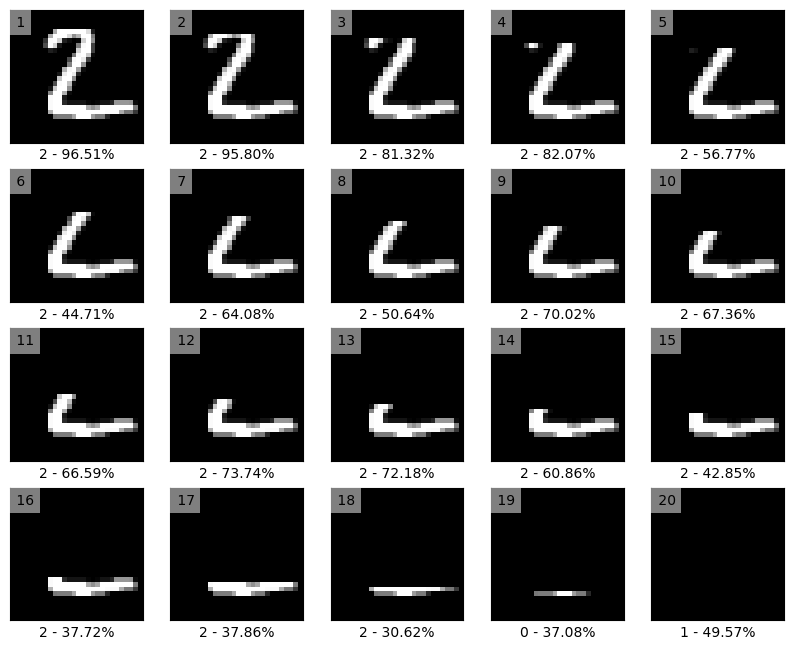

In [33]:
plot_predictions(predictions_mean, imgs)

Figure above: Predicted label and corresponding softmax score of an MC dropout network for an image that is more and more out-of-distribution

We can see in the figure above that the model is less certain on average. The model’s confidence decreases a lot when we remove rows from our image. That is desired behaviour: our model does not know the input, so it should be uncertain. However, we can also see that the model is not perfect:

It maintains a pretty high confidence for images that do not really look like a 2.

The model’s confidence can change a lot when we delete one more row from our images. For example, the model’s confidence jumps from 60.86% to 42.85% between image 14 and 15.

The model seems to be more confident that image 20, without any white pixels, is a 1.

MC dropout is not handling the out-of-distribution data perfectly.